# 02. Neural Network Classification

Types of Classification:

- Binary Classification (true / false)
- Multi-class Classification (more than 2 options)
- Multi-label Classification (target can be assigned more than one option)

![image](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/02-different-classification-problems.png)

## 0. Architecture of a classification neural network

Before we get into writing code, let's look at the general architecture of a classification neural network.

| Hyperparameter | Binary Classification | Multiclass classification |
|----------------|-----------------------|---------------------------|
|**Input layer** shape (`in_features`) | Same as number of features (e.g. 5 for age, sex, height, weight, smoking status in heart disease prediction) | Same as binary classification |
|**Hidden layer(s)** |  Problem specific, minimum = 1, maximum = unlimited | Same as binary classification |
|**Neurons per hidden layer** | Problem specific, generally 10 to 512 | Same as binary classification |
|**Output layer shape** (`out_features`) | 1 (one class or the other) | 1 per class (e.g. 3 for food, person or dog photo) |
|**Hidden layer activation** | Usually [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU) (rectified linear unit) but can be [many others](https://en.wikipedia.org/wiki/Activation_function#Table_of_activation_functions) | Same as binary classification |
|**Output activation**| Sigmoid (`torch.sigmoid` in PyTorch) | Softmax (`torch.softmax` in PyTorch) |
|**Loss function**| Binary crossentropy (`torch.nn.BCELoss` in PyTorch) | Cross entropy (`torch.nn.CrossEntropyLoss` in PyTorch) |
|**Optimizer** | [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) (stochastic gradient descent), [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) | Same as binary classification |

## 1. Make classification data and get it ready

Let's begin by making some data.

We'll use the `make_circles()` method from Scikit-Learn to generate two circles with different coloured dots.

In [1]:
from sklearn.datasets import make_circles

# Make 1000 samples 
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

In [2]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


In [3]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({
    "X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [4]:
# Check different labels
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

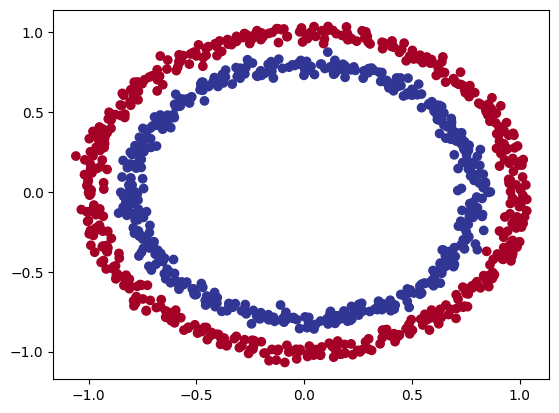

In [5]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu);

### 1.1 Input and output shapes

One of the most common errors in deep learning is shape errors.

In [6]:
# Check the shape of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
# It often helps to view the values and shapes of a single sample (features and labels).
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


This tells us the second dimension for X means it has two features (vector) where as y has a single feature (scalar).

We have two inputs for one output.

### 1.2 Turn data into tensors and create train and test splits

We've investigated the input and output shapes of our data, now let's prep it for PyTorch and for modelling. We need to:
- Turn our data into tensors
- Split our data into training and test sets



In [8]:
# Turn data into tensors
# Otherwise this causes issues with computations later on
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first 5 samples
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

Now our data is in tensor format, let's split it into training and test sets.

To do so, let's use the helpful function `train_test_split()` from Scikit-Learn.

We'll use `test_size=0.2` (80% training, 20% testing) and because the split happens randomly across the data, let's use `random_state=42` so the split is reproducible.

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

We'll break it down into a few parts.

- Setting up device agnostic code (so our model can run on CPU or GPU if it's available).
- Constructing a model by subclassing nn.Module.
- Defining a loss function and optimizer.
- Creating a training loop (this'll be in the next section).


In [10]:
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Let's create a model class that:

- Subclasses nn.Module (almost all PyTorch models are subclasses of nn.Module).
- Creates 2 nn.Linear layers in the constructor capable of handling the input and output shapes of X and y.
- Defines a forward() method containing the forward pass computation of the model.
- Instantiates the model class and sends it to the target device.


In [11]:
# 1. Construct a model class that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # 5 hidden units / neurons
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    # 3. Define a forward method
    def forward(self, x):
        first_computation = self.layer_1(x)
        return self.layer_2(first_computation)

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

**[A visual representation of the NN](https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.02353&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false
) below**

![image](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/02-tensorflow-playground-linear-activation.png)

You can also do the same as above using `nn.Sequential`.

`nn.Sequential` performs a forward pass computation of the input data through the layers in the order they appear.

In [12]:
# Replicate CircleModelV0 with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

`nn.Sequential` is fantastic for straight-forward computations, however, as the namespace says, it always runs in sequential order.

So if you'd something else to happen (rather than just straight-forward sequential computation) you'll want to define your own custom `nn.Module` subclass.

In [13]:
# Make predictions with the model (just to see what it looks like, this has no value)
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.1739],
        [-0.3934],
        [ 0.2508],
        [-0.2936],
        [ 0.0116],
        [-0.1206],
        [-0.5490],
        [-0.4858],
        [ 0.2603],
        [-0.4108]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup a loss function and optimizer

|Loss function/Optimizer |	Problem type |	PyTorch Code|
|------------------------|---------------|--------------|
|Stochastic Gradient Descent (SGD) optimizer 	|Classification, regression, many others. |	torch.optim.SGD()|
|Adam Optimizer |	Classification, regression, many others. |	torch.optim.Adam()|
|Binary cross entropy loss 	|Binary classification |	torch.nn.BCELossWithLogits or torch.nn.BCELoss|
|Cross entropy loss |	Mutli-class classification| 	torch.nn.CrossEntropyLoss|
|Mean absolute error (MAE) or L1 Loss |	Regression| 	torch.nn.L1Loss|
|Mean squared error (MSE) or L2 Loss |	Regression| 	torch.nn.MSELoss|
|...|...|...|

> PyTorch documentation often refers to loss functions as "loss criterion" or "criterion", these are all different ways of describing the same thing.

In [14]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

Now let's also create an evaluation metric.

An evaluation metric can be used to offer another perspective on how your model is going.

If a loss function measures how wrong your model is, I like to think of evaluation metrics as measuring how right it is.

There are several evaluation metrics that can be used for classification problems but let's start out with accuracy.

Accuracy can be measured by dividing the total number of correct predictions over the total number of predictions.

In [15]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

## 3. Train model

The steps are (just to recap):

1. **Forward pass** - The model goes through all of the training data once, performing its forward() function calculations (model(x_train)).
2. **Calculate the loss** - The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are (loss = loss_fn(y_pred, y_train).
3. **Zero gradients** - The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step (optimizer.zero_grad()).
4. **Perform backpropagation on the loss** - Computes the gradient of the loss with respect for every model parameter to be updated (each parameter with requires_grad=True). This is known as backpropagation, hence "backwards" (loss.backward()).
5. **Step the optimizer (gradient descent)** - Update the parameters with requires_grad=True with respect to the loss gradients in order to improve them (optimizer.step()).

### 3.1 Going from raw model outputs to predicted labels (logits -> prediction probablities -> prediction labels)


In [16]:
# View the frist 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.1739],
        [-0.3934],
        [ 0.2508],
        [-0.2936],
        [ 0.0116]], device='cuda:0', grad_fn=<SliceBackward0>)

Since our model hasn't been trained, these outputs are basically random.

But what are they?

They're the output of our forward() method which implements two layers of nn.Linear() which internally calls the following equation:

$$ \mathbf{y} = x \cdot \mathbf{Weights}^T + \mathbf{bias} $$

The raw outputs (unmodified) of this equation ($\mathbf{y}$) and in turn, the raw outputs of our model are often referred to as [logits](https://datascience.stackexchange.com/questions/31041/what-does-logits-in-machine-learning-mean/31045#31045).

However, these numbers are hard to interpret.

We'd like some numbers that are comparable to our truth labels.

To get our model's raw outputs (logits) into such a form, we can use the sigmoid activation function.

Let's try it out.

In [17]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4566],
        [0.4029],
        [0.5624],
        [0.4271],
        [0.5029]], device='cuda:0', grad_fn=<SigmoidBackward0>)

They're now in the form of **prediction probabilities**. Since we are dealing w binary classification, our ideal outputs are 0 or 1. These values can be viewed as a decision boundary.

To turn our prediction probabilities in prediction labels, we can round the outputs of the sigmoid activation function.

In [18]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 1., 0., 1.], device='cuda:0', grad_fn=<SqueezeBackward0>)

> Note: The use of the sigmoid activation function is often only for binary classification logits. For multi-class classification, we'll be looking at using the softmax activation function

### 3.2 Building a training and testing loop

In [19]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls
  
    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train) 
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train) 
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred) 

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70708, Accuracy: 48.62% | Test loss: 0.69558, Test acc: 54.00%
Epoch: 10 | Loss: 0.70318, Accuracy: 48.75% | Test loss: 0.69334, Test acc: 53.50%
Epoch: 20 | Loss: 0.70066, Accuracy: 49.25% | Test loss: 0.69226, Test acc: 53.00%
Epoch: 30 | Loss: 0.69892, Accuracy: 49.38% | Test loss: 0.69175, Test acc: 53.00%
Epoch: 40 | Loss: 0.69765, Accuracy: 49.50% | Test loss: 0.69156, Test acc: 52.50%
Epoch: 50 | Loss: 0.69670, Accuracy: 49.88% | Test loss: 0.69153, Test acc: 51.50%
Epoch: 60 | Loss: 0.69598, Accuracy: 49.50% | Test loss: 0.69160, Test acc: 52.00%
Epoch: 70 | Loss: 0.69542, Accuracy: 50.00% | Test loss: 0.69173, Test acc: 50.50%
Epoch: 80 | Loss: 0.69499, Accuracy: 49.88% | Test loss: 0.69189, Test acc: 50.50%
Epoch: 90 | Loss: 0.69464, Accuracy: 49.50% | Test loss: 0.69206, Test acc: 51.50%



It looks like it went through the training and testing steps fine but the results don't seem to have moved too much.

The accuracy barely moves above 50% on each data split.

And because we're working with a balanced binary classification problem, it means our model is performing as good as random guessing (with 500 samples of class 0 and class 1 a model predicting class 1 every single time would achieve 50% accuracy).


## 4. Make predictions and evaluate the model

Let's make a plot of our model's predictions, the data it's trying to predict on and the decision boundary it's creating for whether something is class 0 or class 1.

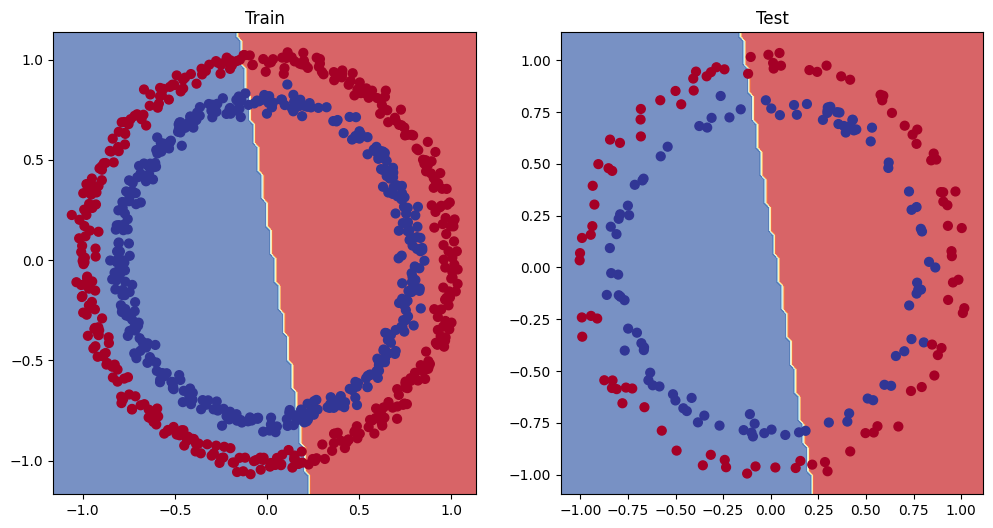

In [20]:
from helper_functions import plot_predictions, plot_decision_boundary
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

Our model is underfitting, meaning it's not learning predictive patterns from the data.

How could we improve this?

## 5. Improving a model

Let's try to fix the underfitting problem. Focusing specifically on the model (not the data), there are a few ways to do this:

|**Model improvement technique*** |	**What does it do?** |
|---------------------------------|----------------------|
|Add more layers |	Each layer potentially increases the learning capabilities of the model with each layer being able to learn some kind of new pattern in the data, more layers is often referred to as making your neural network deeper.|
|Add more hidden units |	Similar to the above, more hidden units per layer means a potential increase in learning capabilities of the model, more hidden units is often referred to as making your neural network wider.|
|Fitting for longer (more epochs) |	Your model might learn more if it had more opportunities to look at the data.|
|Changing the activation functions 	|Some data just can't be fit with only straight lines (like what we've seen), using non-linear activation functions can help with this (hint, hint).|
|Change the learning rate |	Less model specific, but still related, the learning rate of the optimizer decides how much a model should change its parameters each step, too much and the model overcorrects, too little and it doesn't learn enough.|
|Change the loss function 	|Again, less model specific but still important, different problems require different loss functions. For example, a binary cross entropy loss function won't work with a multi-class classification problem.|
|Use transfer learning |	Take a pretrained model from a problem domain similar to yours and adjust it to your own problem. We cover transfer learning in notebook 06.|

Let's see what happens if we add an extra layer to our model, fit for longer (epochs=1000 instead of epochs=100) and increase the number of hidden units from 5 to 10.

We'll follow the same steps we did above but with a few changed hyperparameters.

In [21]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10) # extra layer
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        
    def forward(self, x): # note: always make sure forward is spelt correctly!
        # Creating a model like this is the same as below, though below
        # generally benefits from speedups where possible.
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        # return z
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [22]:
# loss_fn = nn.BCELoss() # Requires sigmoid on input
loss_fn = nn.BCEWithLogitsLoss() # Does not require sigmoid on input
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [23]:
torch.manual_seed(42)

epochs = 1000 # Train for longer

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> predicition probabilities -> prediction labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Accuracy: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%


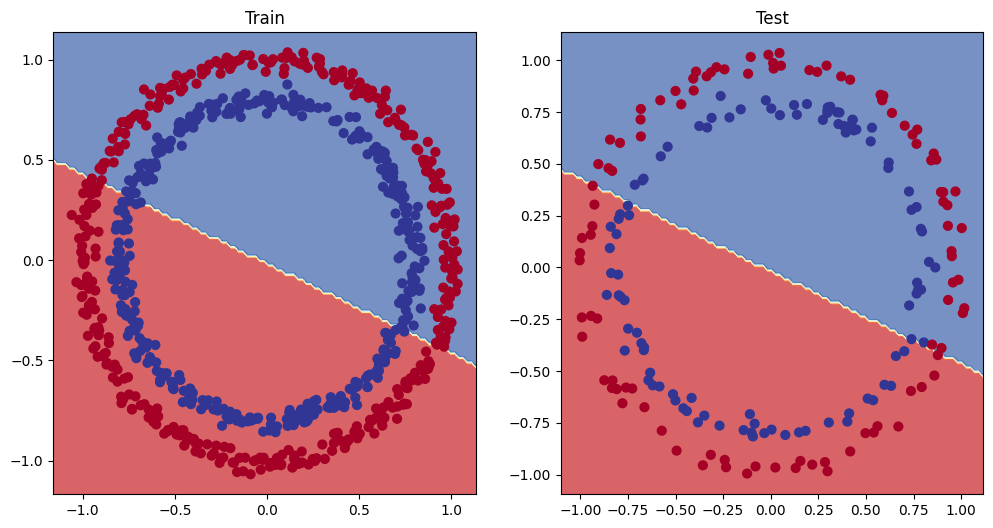

In [24]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

## 6 The missing piece: non-linearity

### 6.1 Recreating non-linear data (red and blue circles)

First, let's recreate the data to start off fresh. We'll use the same setup as before.


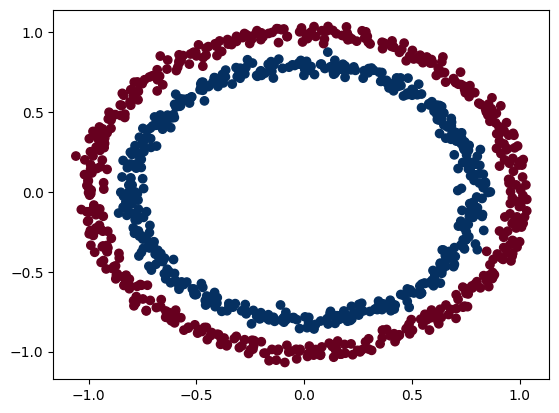

In [25]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [26]:
# Convert to tensors and split into train and test sets
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity

PyTorch has a bunch of [ready-made non-linear activation functions](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) that do similiar but different things.

One of the most common and best performing is [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) (rectified linear-unit, `torch.nn.ReLU()`).

In [27]:
# Build model with non-linear activation function
from torch import nn

class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model 
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Intersperse the ReLU activation function between layers
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


**Sidenote:** `nn.Linear` just means it's a layer in a NN where each `in_feature` is connected to each `out_feature`!

In [28]:
# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [29]:
# Fit the model
torch.manual_seed(42)
epochs = 2000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calculate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy: 79.00%
Epoch: 1000 | Loss: 0.56818, Accuracy: 87.75% | Test Loss: 0.57378, Test Accuracy: 86.50%
Epoch: 1100 | Loss: 0.

In [30]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

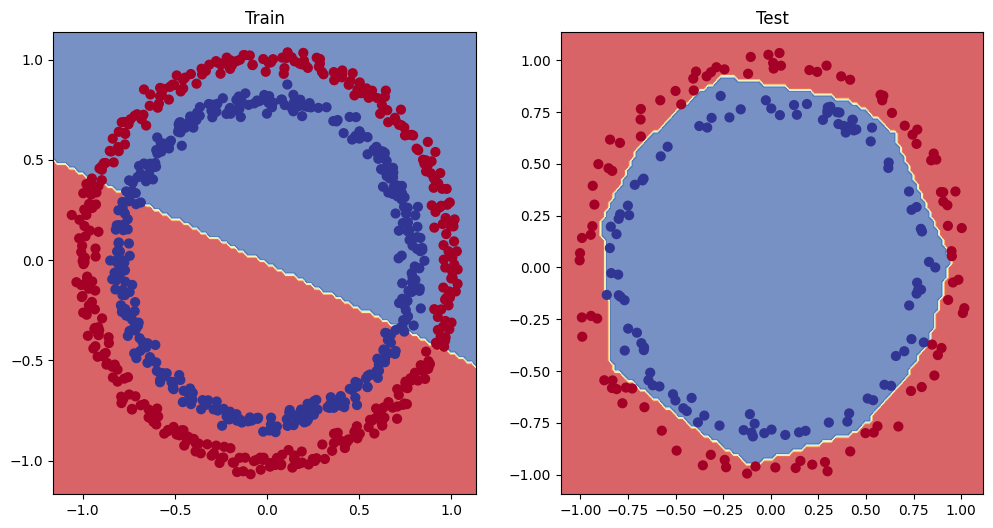

In [31]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

## 7. Replicating non-linear activation functions

Skipping, know all this stuff already and not relevant as torch has it implemented

## 8. Putting things together by building a multi-class Pytorch model

Bow let's put it all together using a multi-class classification problem. Recall a binary classification problem deals with classifying something as one of two options (e.g. a photo as a cat photo or a dog photo) where as a multi-class classification problem deals with classifying something from a list of more than two options (e.g. classifying a photo as a cat a dog or a chicken).

### 8.1 Creating multi-classificatino data

To begin a multi-class classification problem, let's create some multi-class data.

To do so, we can leverage Scikit-Learn's `make_blobs()` method. This method will create however many classes (using the `centers` param) we want. Specifically, we do the following:
1. Create some multi-class data with `make_blobs()`
2. Turn the data into tensors (the default of `make_blobs` is to use NumPy arrays)
3. Split the data into train and test data
4. Visualize the data

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


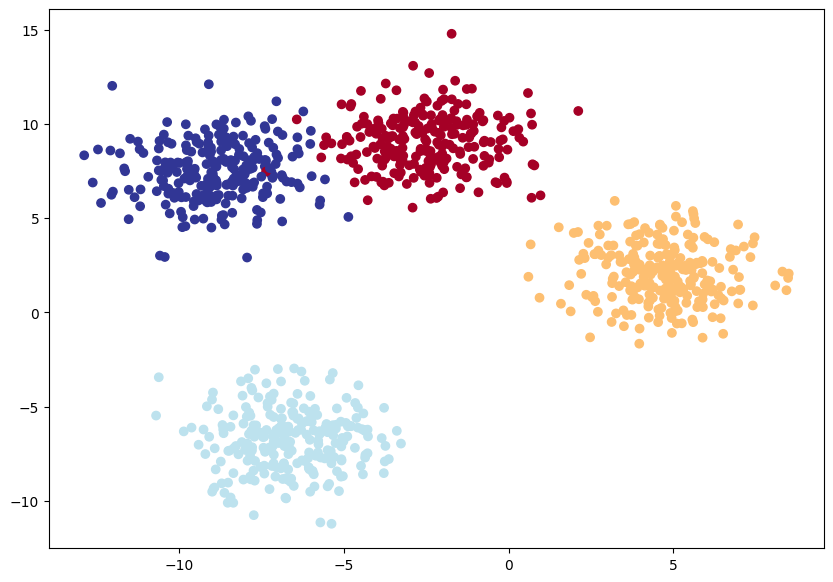

In [32]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(
    n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(
    X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

## 8.2 Building a multi-class classification model in PyTorch

In [33]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [34]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [35]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), 
                            lr=0.1) # exercise: try changing the learning rate here and seeing what happens to the model's performance

In [38]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work). We will get logits out
model_4(X_blob_train.to(device))[:5]

tensor([[-1.2711, -0.6494, -1.4740, -0.7044],
        [ 0.2210, -1.5439,  0.0420,  1.1531],
        [ 2.8698,  0.9143,  3.3169,  1.4027],
        [ 1.9576,  0.3125,  2.2244,  1.1324],
        [ 0.5458, -1.2381,  0.4441,  1.1804]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [37]:
# How many elements in a single prediction sample?
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES 

(torch.Size([4]), 4)

We now need to go from `logits -> prediction probabilities -> prediction labels`, but unlike using the sigmoid for binary classification we use the [softmax](https://en.wikipedia.org/wiki/Softmax_function) activation function.

The softmax function calculates the probability of each prediction class being the actual predicted class compared to all other possible classes.

In [39]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1) 
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]], device='cuda:0',
       grad_fn=<SliceBackward0>)




These prediction probablities are essentially saying how much the model thinks the target X sample (the input) maps to each class.

Since there's one value for each class in y_pred_probs, the index of the highest value is the class the model thinks the specific data sample most belongs to.

We can check which index has the highest value using torch.argmax().


In [40]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.1872, 0.2918, 0.1495, 0.3715], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(3, device='cuda:0')


You can see the output of torch.argmax() returns 3, so for the features (X) of the sample at index 0, the model is predicting that the most likely class value (y) is 3.

> To sum up: A model's raw output is referred to as logits.
>
> For a multi-class classification problem, to turn the logits into prediction probabilities, you use the softmax activation function (torch.softmax).
>
> The index of the value with the highest prediction probability is the class number the model thinks is most likely given the input features for that sample (although this is a prediction, it doesn't mean it will be correct).

### 8.5 Creating a training and testing loop for a multi-class model

We've done many of these steps before so much of this will be practice.

The only difference is that we'll be adjusting the steps to turn the model outputs (logits) to prediction probabilities (using the softmax activation function) and then to prediction labels (by taking the argmax of the output of the softmax activation function).

In [41]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 1.04324, Acc: 65.50% | Test Loss: 0.57861, Test Acc: 95.50%
Epoch: 10 | Loss: 0.14398, Acc: 99.12% | Test Loss: 0.13037, Test Acc: 99.00%
Epoch: 20 | Loss: 0.08062, Acc: 99.12% | Test Loss: 0.07216, Test Acc: 99.50%
Epoch: 30 | Loss: 0.05924, Acc: 99.12% | Test Loss: 0.05133, Test Acc: 99.50%
Epoch: 40 | Loss: 0.04892, Acc: 99.00% | Test Loss: 0.04098, Test Acc: 99.50%
Epoch: 50 | Loss: 0.04295, Acc: 99.00% | Test Loss: 0.03486, Test Acc: 99.50%
Epoch: 60 | Loss: 0.03910, Acc: 99.00% | Test Loss: 0.03083, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03643, Acc: 99.00% | Test Loss: 0.02799, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03448, Acc: 99.00% | Test Loss: 0.02587, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03300, Acc: 99.12% | Test Loss: 0.02423, Test Acc: 99.50%


In [42]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[  4.3377,  10.3539, -14.8948,  -9.7642],
        [  5.0142, -12.0371,   3.3860,  10.6699],
        [ -5.5885, -13.3448,  20.9894,  12.7711],
        [  1.8400,   7.5599,  -8.6016,  -6.9942],
        [  8.0727,   3.2906, -14.5998,  -3.6186],
        [  5.5844, -14.9521,   5.0168,  13.2890],
        [ -5.9739, -10.1913,  18.8655,   9.9179],
        [  7.0755,  -0.7601,  -9.5531,   0.1736],
        [ -5.5918, -18.5990,  25.5309,  17.5799],
        [  7.3142,   0.7197, -11.2017,  -1.2011]], device='cuda:0')

 It's possible to skip the torch.softmax() function and go straight from predicted logits -> predicted labels by calling torch.argmax() directly on the logits.

For example, y_preds = torch.argmax(y_logits, dim=1), this saves a computation step (no torch.softmax()) but results in no prediction probabilities being available to use.

In [43]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 99.5%


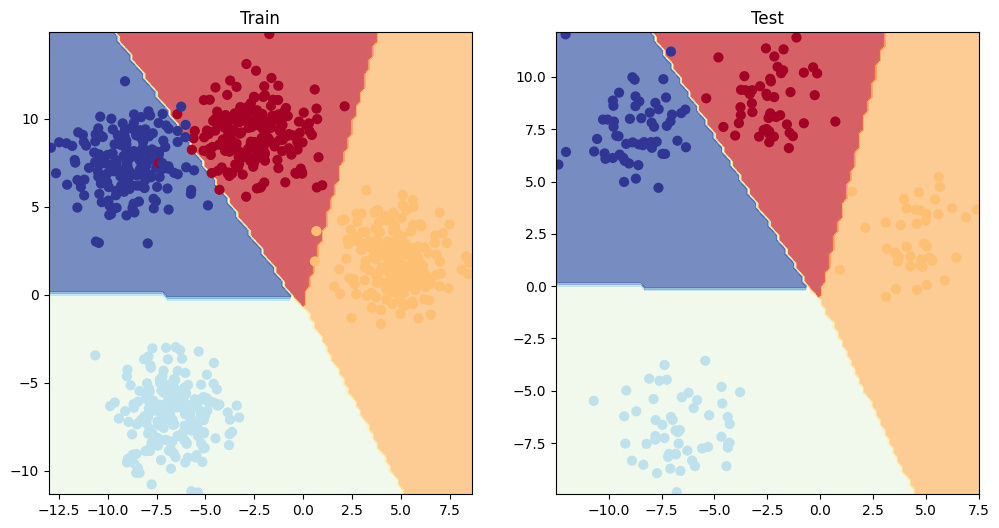

In [44]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9 More classification evaluation metrics

So far we've only covered a couple of ways of evaluating a classification model (accuracy, loss and visualizing predictions).

These are some of the most common methods you'll come across and are a good starting point.

However, you may want to evaluate your classification model using more metrics such as the following:

|Metric name/Evaluation method |	Defintion |	Code|
|------------------------------|-------------|------|
|Accuracy |	Out of 100 predictions, how many does your model get correct? E.g. 95% accuracy means it gets 95/100 predictions correct. |	torchmetrics.Accuracy() or sklearn.metrics.accuracy_score()
|Precision |	Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0). 	|torchmetrics.Precision() or sklearn.metrics.precision_score()
|Recall |	Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives. |	torchmetrics.Recall() or sklearn.metrics.recall_score()
|F1-score |	Combines precision and recall into one metric. 1 is best, 0 is worst.| 	torchmetrics.F1Score() or sklearn.metrics.f1_score()
|Confusion matrix |	Compares the predicted values with the true values in a tabular way, if 100% correct, all values in the matrix will be top left to bottom right (diagnol line). |	torchmetrics.ConfusionMatrix or sklearn.metrics.plot_confusion_matrix()
|Classification report |	Collection of some of the main classification metrics such as precision, recall and f1-score. |	sklearn.metrics.classification_report()

In [50]:
from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

tensor(0.9950, device='cuda:0')